In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.misc import logsumexp

% matplotlib inline

## 1. Reproduce Wiggins' K-means Result 

### Read in data and obtain the range values for the centroids to run Wiggins' K means algorithm

In [22]:
#read Wiggins' data into a list
Wiggins_data = []
with open("w06-data.tbl.txt", "r") as W:
    W.readline()
    for line in W:
        Wiggins_data.append(line.strip().split()[2:])

In [23]:
#change list into numpy array for manipulation by functions (cara for caraway, kiwi is already short enough)
#need data in float type for proper use with numpy in later functions
cara_kiwi = np.array(Wiggins_data).astype(float)

In [24]:
#range values on the centroids are bound by the maximum and minimum values of the gene expression
cara_max, kiwi_max = cara_kiwi.max(axis=0)
cara_min, kiwi_min = cara_kiwi.min(axis=0)

The test I am using here to make sure that we have achieved the "best" solution in this case is to use the distance between the cluster points and the centroid values, namely the minimum distance between a point and its centroid among all of the points in the clusters. 

In [13]:
def Wiggins_k(data, min_gene1, max_gene1, min_gene2, max_gene2, X_rep):
    
    #make v.large to start with!!
    final_tot_dist = 100000000000000
    
    #want to repeat at least 20 times (until convergence...)
    #to ensure that 20 is enough, use higher X_rep and confirm it converges by comparing final_tot_dist measures 
    for x in range(X_rep):

        tot_dist = 0
        old_tot_dist = 1
        gene1_centroid =  np.random.randint(min_gene1, max_gene1, 5)
        gene2_centroid = np.random.randint(min_gene2, max_gene2, 5)
        data_centroids = np.vstack((gene1_centroid, gene2_centroid)).T

        while tot_dist != old_tot_dist:
            #assignment step for assigning each data point to a centroid
            assign = []
            old_tot_dist = tot_dist
            tot_dist = 0
            for point in data:
                #make a temporary list for each of the centroids (not for every point)
                point_dist = []
                for centroid in data_centroids:
                    point_dist.append(np.sqrt(np.square(point[0] - centroid[0]) + (np.square(point[1] - centroid[1]))))
                assign.append(np.argmin(point_dist))
                tot_dist += min(point_dist)
            
            #update step (update centroids as the average of the cluster points)
            #get all points that are assigned to each cluster
            #for each centroid - get all points that are associated with the cluster
            for i in range(len(data_centroids)):
                if i in assign:
                    data_centroids[i] = np.mean(np.array(data)[np.where(np.array(assign) == i)], axis=0)
        if tot_dist < final_tot_dist:
            final_tot_dist = tot_dist
            final_assign = assign
            final_data_centroids = data_centroids

    return final_tot_dist, final_assign, final_data_centroids

In [14]:
Wck_tot_dist_20, Wck_final_assign_20, Wck_final_centroids_20 = Wiggins_k(cara_kiwi, cara_min, cara_max, kiwi_min, kiwi_max, 20)

In [15]:
Wck_tot_dist_50, Wck_final_assign_50, Wck_final_centroids_50 = Wiggins_k(cara_kiwi, cara_min, cara_max, kiwi_min, kiwi_max, 50)

In [16]:
Wck_tot_dist_100, Wck_final_assign_100, Wck_final_centroids_100 = Wiggins_k(cara_kiwi, cara_min, cara_max, kiwi_min, kiwi_max, 100)

In [18]:
Wck_tot_dist_200, Wck_final_assign_200, Wck_final_centroids_200 = Wiggins_k(cara_kiwi, cara_min, cara_max, kiwi_min, kiwi_max, 200)

In [19]:
print(Wck_tot_dist_20, Wck_tot_dist_50, Wck_tot_dist_100, Wck_tot_dist_200)

505310.29833259253 503584.65209222527 502642.9633075772 502642.9633075772


It appears that the basic statistic we are using (the minimum distance between a centroid and its closest point) doesn't change between 100 and 200 repeitions of algorithm, and so I will use the values for the 100 repetition case for visualization. 

In [42]:
#look at final centroids values
Wck_final_centroids_100

array([[ 259,  223],
       [ 726, 4141],
       [3540, 2364],
       [2521,  272],
       [ 945, 1803]])

In [25]:
def visualize_data(data, mu, C, outpng):
    '''
    ***Sean Eddy's/MCB112's code***
    
    visualize_data():

    This might give you a starting point that saves some matplotlib
    machinations; you can certainly spiff this up from here.

    Input:
       data[i,g] : count data for each cell i, for each gene g
       mu[q,g]   : array of mean counts for mixture q, gene g
       C[i]      : assignment of cell i to a cluster 0..Q-1
       outpng    : save figure to PNG file (must end in .png; example 'foo.png')

    '''
    N, G  = np.shape(data)
    Q, G2 = np.shape(mu)
    assert G == G2
    assert len(C) == N

    # We can assign colors to up to Q=10 components. If you want more, add more.
    colormap = ['xkcd:orange', 'xkcd:olive',     'xkcd:azure',    'xkcd:rose', 'xkcd:mustard', 
                'xkcd:peach',  'xkcd:turquoise', 'xkcd:lavender', 'xkcd:rust', 'xkcd:red']

    fig, ax = plt.subplots()
    for i in range(N):
        edgecolor = colormap[ C[i]]
        fillcolor = 'w'
        shape     = 'o'
        ax.loglog( data[i,0], data[i,1], marker=shape, mec=edgecolor, mfc=fillcolor, mew=1.5)

    for q in range(Q):
        ax.loglog(mu[q,0], mu[q,1], '*k', ms=10)

    ax.set_xlabel('caraway (counts)')
    ax.set_ylabel('kiwi (counts)')

    fig.savefig(outpng)


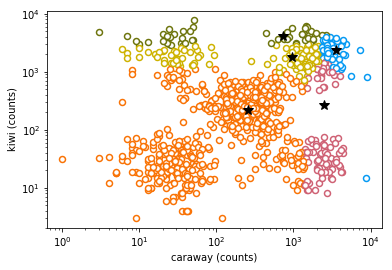

In [26]:
visualize_data(cara_kiwi, Wck_final_centroids_100, Wck_final_assign_100, 'Wiggins_Wck_100.png')

The scale that the data is being visualized on is the logscale. Here, we can see that the points cluster to the top right of the graph. We are measuring distance in logspace, so the larger the numbers, the greater the difference will be between those numbers. It seems that we should either fix our test statistic so that larger numbers don't have so much more weight than smaller numbers, or we could put all of our data into logspace. 

## 2. Mixture Negative Binomial Fitting 

In [33]:
def define_params(data):
    
    cara = data.T[0]
    kiwi = data.T[1]

    cara_max, kiwi_max = cara_kiwi.max(axis=0)
    cara_min, kiwi_min = cara_kiwi.min(axis=0)
    cara_centroid =  np.random.randint(cara_min, cara_max, 5)
    kiwi_centroid = np.random.randint(kiwi_min, kiwi_max, 5)
    centroids = np.vstack((cara_centroid, kiwi_centroid)).T
    
    #define pi values and phi
    #start from random probability across all centroids 
    pi = np.random.rand(5)
    Z = sum(pi)
    pi = [p/Z for p in pi]

    return centroids, pi

In [34]:
def expectation(data, centroids, pi, phi):
    #EXPECTATION STEP 
    posteriors = np.zeros((len(data), len(centroids)))
    LLH = 0 
    #calculate posterior probabilities (P(x|theta_q) and normalize)
    for j, point in enumerate(data):
        nums = []
        for i, centroid in enumerate(centroids):
            #calculating the expectation step
            #need to calculate the posterior
            n = 1/phi
            log_pi_q = np.log(pi[i])
            cara_p = 1/(1+(centroid[0])*phi)
            kiwi_p = 1/(1+(centroid[1])*phi)
            cara_logpmf = scipy.stats.nbinom.logpmf(point[0], n, cara_p)
            kiwi_logpmf = scipy.stats.nbinom.logpmf(point[1], n, kiwi_p)

            num = log_pi_q + cara_logpmf + kiwi_logpmf
            nums.append(num)
        denom = logsumexp(nums)
        #track loglikelihoods
        LLH += denom
        #add posterior probability to matrix which corresponds to point j
        posteriors[j] = [nu-denom for nu in nums]

    posteriors = np.exp(posteriors)
    return posteriors, LLH

In [35]:
def maximization(data, posteriors, centroids, pi):
    #MAXIMIZATION STEP
    for i, centroid in enumerate(centroids):

        num_cara = 0
        num_kiwi = 0
        denom = 0

        for j, point in enumerate(data):
            #P(q|Xj)(posterior for one point at one centroid)
            post = posteriors[j, i]
            point_cara = point[0]
            point_kiwi = point[1]

            num_cara += post*point_cara
            num_kiwi += post*point_kiwi

            denom += post

        centroid_cara = num_cara/denom
        centroid_kiwi = num_kiwi/denom
        pi_q_new = denom/len(cara_kiwi)
        #update centroids list with new centroids
        centroids[i] = [centroid_cara, centroid_kiwi]
        pi[i] = pi_q_new
    
    return centroids, pi

### Now, use all of the functions defined for this section to run the mixture negative binomial fitting 

I'll use the loglikehihood value (which should get smaller and smaller until converging) as a test-statistic because we are using maximum likelihood estimation to cluster the data. 

In [36]:
#initialize to v. big NEG number
final_LLH_ck = -1000000000000000000

for x in range(100):   
    
    phi = 0.3
    ck_centroids, ck_pi = define_params(cara_kiwi)

    old_LLH = 2000
    LLH_ck = 1000

    while np.abs(old_LLH - LLH_ck) > 1:

        old_LLH = LLH_ck
        posteriors_ck, LLH_ck = expectation(cara_kiwi, ck_centroids, ck_pi, phi)

        ck_centroids, ck_pi = maximization(cara_kiwi, posteriors_ck, ck_centroids, ck_pi)

    #update posterior probs    
    posteriors_ck, LLH_ck = expectation(cara_kiwi, ck_centroids, ck_pi, phi)
    print(LLH_ck)
    #get updated assignments
    assignments = np.argmax(posteriors_ck, axis=1)
    
    if LLH_ck > final_LLH_ck:
        final_LLH_ck = LLH_ck
        final_assignments = assignments
        final_posteriors_ck = posteriors_ck
        final_centroids_ck = ck_centroids
        final_pi_ck = ck_pi

-14147.793939848334
-14147.79398434039
-14147.794075575997
-15252.327637466955
-15250.764083095071
-14147.793939023397
-14147.793940027768
-14147.793964107454
-15252.052118005078
-15254.562543818993
-14147.793983018306
-14147.79393914041
-15247.7287807703
-14147.793940031392
-15254.376588334544
-15249.357163498438
-15252.524044254573
-14147.7939391435
-14147.793939394978
-14147.793940025924
-14147.794084976984
-14147.793964590845
-14147.793910182734
-14147.794088651293
-14147.793984196514
-14147.79410107944
-14147.793939394121
-14147.793939022333
-15252.426705841643
-15252.570218132889
-14147.793939060552
-14147.793996162834
-15254.318309965076
-14147.793939143015
-14147.793985396127
-15252.970090754567
-15252.604641806676
-15243.189569136583
-14147.793982892403
-15252.384278532258
-15251.633292557752
-15252.327830250808
-15249.932655539058
-15252.488431771946
-15254.624299142977
-15252.201239957747
-15252.559601837453
-15254.431990091229
-15254.392909236467
-15254.542494310164
-15254.

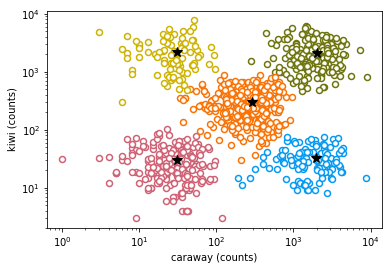

In [37]:
visualize_data(cara_kiwi, final_centroids_ck, final_assignments, 'Wiggins_HMC_EM.png')

In [43]:
#check relative proportions of each "cell type" --> final_pi_ck
#check estimated mean expression levels --> final_centroids_ck
final_pi_ck, final_centroids_ck

([0.396283516023662,
  0.2005773594422079,
  0.1178185051541808,
  0.195511654694828,
  0.08980896468512169],
 array([[ 292,  295],
        [2039, 2095],
        [1962,   32],
        [  31,   30],
        [  31, 2199]]))

In [39]:
#check final loglikelihood value - our test-statistic for best fit
final_LLH_ck

-15252.868295237797

## 3. Find a simple fix for K means 

In log scales the differences between bigger numbers give further differences, and this is skewing the kmeans to the larger numbers for the centroid values. So we can put all data points in logscale to account for this to correct it (easy) or we can weight differences (harder, probably unncessary). 

In [30]:
log_cara_kiwi = np.log(cara_kiwi)
log_cara_max, log_kiwi_max = log_cara_kiwi.max(axis=0)
log_cara_min, log_kiwi_min = log_cara_kiwi.min(axis=0)

In [31]:
#make v.large to start with
final_tot_dist = 100000000000000

for x in range(100):
    
    tot_dist = 0
    old_tot_dist = 1
    log_cara_centroid =  np.random.randint(log_cara_min, log_cara_max, 5)
    log_kiwi_centroid = np.random.randint(log_kiwi_min, log_kiwi_max, 5)
    log_cara_kiwi_centroids = np.vstack((log_cara_centroid, log_kiwi_centroid)).T

    while tot_dist != old_tot_dist:
        #assignment step for assigning each data point to a centroid
        assign = []
        old_tot_dist = tot_dist
        tot_dist = 0
        for point in log_cara_kiwi:
            #make a temporary list for each of the centroids (not for every point)
            point_dist = []
            for centroid in log_cara_kiwi_centroids:
                #try diff way of getting the Euclidean distance
                point_dist.append(np.sqrt(np.square(point[0] - centroid[0]) + (np.square(point[1] - centroid[1]))))
            assign.append(np.argmin(point_dist))
            tot_dist += min(point_dist)
        #update step (update centroids as the average of the cluster points)
        #get all points that are assigned to each cluster
        #for each centroid - get all points that are associated with the cluster

        for i in range(len(log_cara_kiwi_centroids)):
            if i in assign:
                log_cara_kiwi_centroids[i] = np.mean(np.array(log_cara_kiwi)[np.where(np.array(assign) == i)], axis=0)
                
    print(tot_dist)
    if tot_dist < final_tot_dist:
        final_tot_dist = tot_dist
        final_assign = assign
        final_log_cara_kiwi_centroids = log_cara_kiwi_centroids
print(final_tot_dist)

1123.8596891401019
957.3025108886209
957.3025108886209
1612.898958838226
1172.7298882006135
1288.3609444118426
1159.745767156562
1495.3378493728046
1482.184467259836
1467.3474321438853
1455.256753981248
957.3025108886209
1168.584844791793
1159.745767156562
1159.745767156562
1492.2097598687492
1123.8596891401019
1340.9785126454335
1414.1129781660472
1165.0123787800223
1165.0123787800223
1512.034369814706
1455.256753981248
1462.2291985660042
1469.2804221555025
957.3025108886209
1159.745767156562
1203.755927392861
1455.256753981248
1455.256753981248
1169.345196915591
1495.3378493728046
1466.0851461451919
1159.745767156562
957.3025108886209
957.3025108886209
1159.745767156562
1495.3378493728046
1165.0123787800223
1168.584844791793
1462.2291985660042
1169.345196915591
1502.3521675830805
1460.3749875591286
1391.6307955090651
1165.0123787800223
1471.764068753195
1468.624297029236
1462.7941849668196
1169.9872394056392
1166.7271456057804
1521.3383971966352
1340.9785126454335
1340.9785126454335


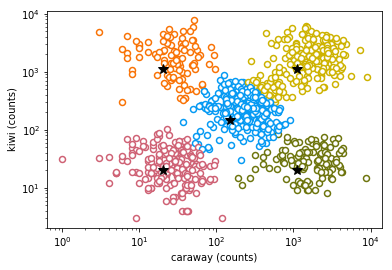

In [32]:
visualize_data(cara_kiwi, np.exp(final_log_cara_kiwi_centroids), final_assign, 'Wiggins_HMC_log.png')

Of note on these algorithms: One thing to be careful of is overfitting, for any of these algorithms. We are currently setting 5 clusters, but if we were to try to use more, we may overfit in either case. Using a method that doesn't require us to choose the number of clusters beforehand, or to randomly choose a number of clusters within a reasonable range may make the clustering less biased. 